In [2]:
from CONSTANT import *
from tools import *
import pandas as pd
import numpy as np
from torch.utils.data import (TensorDataset, DataLoader, SequentialSampler, WeightedRandomSampler)

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoderLayer, TransformerDecoder

from models import *

import torch

from torch import nn
import torch.nn.functional as F

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


use_cuda = False
valid='loso'

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
print('using', device)

using cpu


In [13]:
maskp = .25
np.random.choice([0, 1], size=4, p=[maskp, 1-maskp])

array([0, 1, 1, 1])

In [21]:
np.random.binomial(n=1, p=0.5, size=[10, 4])

array([[0, 0, 0, 1],
       [0, 0, 1, 1],
       [1, 0, 0, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 1]])

In [2]:
from representation.SigRepre import MultiSignalRepresentation
from models.MER import SignalSample

In [3]:
# class DataPrepare(object):

#     def __init__(self,
#                  args,
#                  target,
#                  data,
#                  train_index,
#                  test_index,
#                  device,
#                  batch_size=64):

#         self.args = args

#         X, y = join_signals(data, target=target)
#         xtrain, ytrain, xtest, ytest = X[train_index], y[train_index], X[
#             test_index], y[test_index]

#         if self.args.debug:
#             xtrain, ytrain, xtest, ytest = xtrain[:
#                                                   1000], ytrain[:1000], xtest[:100], ytest[:100]

#         print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

#         xtrain = torch.from_numpy(xtrain).to(torch.float32)
#         xtest = torch.from_numpy(xtest).to(torch.float32)

#         self.xtrain, self.xtest = xtrain.to(device), xtest.to(device)

#         ytrain = torch.from_numpy(ytrain)
#         ytest = torch.from_numpy(ytest)

#         self.ytrain, self.ytest = ytrain.to(device), ytest.to(device)

#         if args.target in ['valence', 'arousal']:
#             self.ytrain = self.ytrain.to(torch.float32)
#             self.ytest = self.ytest.to(torch.float32)

#         self.batch_size = batch_size

#     def get_data(self):
#         train_data = TensorDataset(self.xtrain, self.ytrain)
#         test_data = TensorDataset(self.xtest, self.ytest)

#         train_sampler = SequentialSampler(train_data)
#         train_dataloader = DataLoader(train_data,
#                                       sampler=train_sampler,
#                                       batch_size=self.batch_size,
#                                       drop_last=False)

#         test_sampler = SequentialSampler(test_data)
#         test_dataloader = DataLoader(test_data,
#                                      sampler=test_sampler,
#                                      batch_size=self.batch_size,
#                                      drop_last=False)

#         return train_dataloader, test_dataloader

In [3]:
class Params(object):
    def __init__(self, lr=0.001, epoch=100, valid='loso', target='valence', batch_size=64,):
        self.batch_size = batch_size
        self.valid = valid
        self.target = target
        self.epoch = epoch
        self.lr = lr
        self.metrics_dict = {}
        self.debug = True
        self.out_channels = 32
        self.out_channels = 32
        self.hidden_size = 64
        self.num_layers = 1
        self.fcn_input = 50432
        self.dropout=0.2
        self.use_cuda=False
        self.device=torch.device(
            'cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')

In [18]:
spliter = load_model(r'./processed_signal/HKU956/400_4s_step_2s_spliter.pkl')
data = pd.read_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')
# data = pd.read_csv(r'./processed_signal/HKU956/400_4s_step_2s.csv')
# spliter = load_model(r'./processed_signal/HKU956/772_12s_step_6s_spliter5.pkl')
# data = pd.read_pickle(r'./processed_signal/HKU956/772_12s_step_6s.pkl')

for k in spliter[valid]:
    train_index = k['train_index']
    test_index = k['test_index']
    break

In [19]:
args = Params()

In [20]:
dataprepare = DataPrepare(args=args, target='valence', data=data, train_index=train_index, test_index=test_index, device=device)
# train_dataloader, test_dataloader = dataprepare.get_data()

Target distribution:
1    15755
0     6972
dtype: int64
(1000, 4, 400) (1000, 1) (100, 4, 400) (100, 1)
Train target distribution
1    724
0    276
dtype: int64
Test target distribution
1    57
0    43
dtype: int64


In [21]:
xtest = dataprepare.xtest
xtrain = dataprepare.xtrain

In [22]:
xtest.shape, xtrain.shape

(torch.Size([100, 4, 400]), torch.Size([1000, 4, 400]))

In [23]:
from models.MER import MERClassifer

In [ ]:
# model = SignalSample()
# rep = MultiSignalRepresentation(output_size=40, device=args.device, pretrained=True)
# rep.load_state_dict(torch.load(r'./output/0.0001_256_maskp0.8_checkpoint.pt'))
# rep.fcn = MERClassifer(args, 2)
# model.output_layer = rep

In [25]:
xtest.shape

torch.Size([100, 4, 400])

In [26]:
xtest[:, 0, :].reshape(-1, 1, 400).shape

torch.Size([100, 1, 400])

In [27]:
model = MultiSignalRepresentation(
    output_size=40, pretrained=False, device=args.device)
model.to(args.device)
model.output_layer = MERClassifer(args, 2)

print(model(xtest[:2]).shape)

torch.Size([2, 2])


In [11]:
# model = MultiSignalRepresentation(output_size=40, device=args.device)
# model.load_state_dict(torch.load(r'./representation/mask08ep13.pt'))

<All keys matched successfully>

In [14]:
model.fcn = MERClassifer(args, 2)

In [12]:
model(xtest[:10]).shape

torch.Size([10, 2])

In [5]:
# spliter = load_model(r'./processed_signal/WESAD/400_4s_step_2s_spliter.pkl')
# data = pd.read_pickle(r'./processed_signal/WESAD/400_4s_step_2s.pkl')
# # data = pd.read_csv(r'./processed_signal/HKU956/400_4s_step_2s.csv')

# for k in spliter[valid]:
#     train_index = k['train_index']
#     test_index = k['test_index']
#     break

In [40]:
xtest = dataprepare.xtest[:8]
bvp = xtest[:, 0, :].reshape(-1, 1, 400)
bvp.shape

torch.Size([8, 1, 400])

In [44]:
se = SignalEncoder(output_size=64, dropout=0.2)
x = se(bvp)
x.shape

torch.Size([8, 64])

In [78]:
msr = MultiSignalRepresentation(output_size=64, dropout=0.2)
x = msr(xtest, xtest)
x.shape

torch.Size([8, 4, 64])
torch.Size([8, 64, 4])


torch.Size([8, 4, 400])

In [12]:
# model = SigRep.SigRepSimple(args)
# model.load_state_dict(torch.load(r'./output/False_WES_valence_SG_loso_0.0001_512_32/fold4_checkpoint.pt'))
# model.fcn = nn.Sequential(
#     nn.Linear(40 * 4, 16), nn.ReLU(),
#     nn.Linear(16, 8), nn.ReLU(), nn.Dropout(p=args.dropout))
# model.regressor = nn.Linear(8, 1)

# plot model

In [5]:
from torchviz import make_dot
from models import CNNBiLSTM, SigRep

In [6]:
xtest = dataprepare.xtest

In [7]:
model = SigRep.SigRepSimple(args)
model = model.to(device)
yhat = model(xtest)
yhat.shape

torch.Size([100, 1])

In [30]:

model = CNNBiLSTM.CNNBiLSTM(args)
model = model.to(device)
yhat = model(xtest)
make_dot(yhat, params=dict(list(model.named_parameters()))).render("torchviz", format="png")

'rnn_torchviz.png'

In [11]:
xtest.requires_grad

False

In [5]:
# del train_dataloader, test_dataloader

# CNN+LSTM

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
xtest = dataprepare.xtest[:100]
del dataprepare
xtest.shape

torch.Size([100, 4, 400])

In [9]:
# xtest = xtest.to(device)

In [10]:
# # https://blog.csdn.net/Cyril_KI/article/details/125439045
# # https://github.com/ozancanozdemir/CNN-LSTM/blob/main/cnn-lstm.py

# cnns = nn.Sequential(
#     nn.Conv1d(4, 32, 3),
#     nn.ReLU(inplace=True),
#     nn.MaxPool1d(kernel_size=2, stride=1),
#     nn.BatchNorm1d(32),
#     nn.Conv1d(32, 64, 3),
#     nn.MaxPool1d(kernel_size=2, stride=1),
#     nn.BatchNorm1d(64),
#     nn.ReLU(inplace=True),
# )

# lstm1 = nn.LSTM(input_size=64, 
#             hidden_size=256,
#             num_layers=3, batch_first=True,
#             bidirectional=True, dropout=0.5
#             )

# lstm2 = nn.LSTM(input_size=256, 
#             hidden_size=256,
#             num_layers=3, batch_first=True,
#             bidirectional=True, dropout=0.5
#             )
    

# classifier = nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(256, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Linear(512, 2)
#         )

# cnns.to(device)
# lstm1.to(device)
# lstm2.to(device)
# classifier.to(device)

In [11]:
# lstm = nn.Sequential(nn.LSTM(input_size=64, 
#             hidden_size=256,
#             num_layers=3, batch_first=True,
#             bidirectional=True, dropout=0.5
#             )).to(device)

# lstm2 = nn.LSTM(input_size=512, 
#             hidden_size=512,
#             num_layers=3, batch_first=True,
#             bidirectional=True, dropout=0.5
#             ).to(device)

# bn1 = nn.Sequential(nn.BatchNorm1d(256*2),
#                     nn.ReLU(inplace=True),
#         ).to(device)

# bn2 = nn.Sequential(nn.BatchNorm1d(512*2),
#                     nn.ReLU(inplace=True),
#         ).to(device)

In [12]:
# x = cnns(xtest)
# x.shape

In [13]:
# x = cnns(xtest) # output [batch_size, channels, seq_len]
# x = x.permute(0, 2, 1)
# x, _ = lstm(x) # output [batch_size, seq_len, Hin]
# x = x.permute(0, 2, 1)
# x = bn1(x)  # output [batch_size, Hin, seq_len]
# x = x.permute(0, 2, 1)
# x, _ = lstm2(x) # output [batch_size, seq_len, Hin]
# x = x.permute(0, 2, 1)
# x = bn2(x) # output [batch_size, Hin, seq_len]

In [14]:
# x.shape

In [15]:
# x.flatten(start_dim=1).shape

In [16]:
# classifier(x).shape

In [17]:
# x = cnns(xtest) # output [batch_size, channels, seq_len]
# x = x.permute(0, 2, 1)
# x, _ = lstms(x) # output [batch_size, seq_len, Hin]
# # classifier(x).shape

In [18]:
import torch
from torch import nn


class CNNBiLSTM(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.cnns = nn.Sequential(
            nn.Conv1d(4, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, args.out_channels, 3),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
        )

        self.lstm1 = nn.LSTM(input_size=args.out_channels,
                             hidden_size=512,
                             num_layers=args.num_layers, batch_first=True,
                             bidirectional=True
                             )

        self.lstm2 = nn.LSTM(input_size=512 * 2,
                             hidden_size=args.hidden_size,
                             num_layers=args.num_layers, batch_first=True,
                             bidirectional=True
                             )

        self.fcn = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(args.fcn_input, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Linear(512, 2)

        self.regresser = nn.Linear(512, 1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        """
        input [batch_size, channels, seq_len]
        """
        x = self.cnns(x)  # output [batch_size, channels, seq_len]
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)  # output [batch_size, seq_len, Hin]
        x = self.relu(x)
        x, _ = self.lstm2(x)  # output [batch_size, seq_len, Hin]
        x = self.relu(x)
        x = x.flatten(start_dim=1)
        print(x.shape)
        x = self.fcn(x)
        if self.args.target in ['valence', 'arousal']:
            return self.regresser(x)
        else:
            output = torch.sigmoid(self.classifier(x))
            return output


In [16]:
class Params(object):
    def __init__(self):
        super().__init__()
        self.out_channels = 64
        self.hidden_size = 256
        self.num_layers = 3
        self.fcn_input = 201728
        self.target = 'valence_label'
        self.device = torch.device('cuda')
        self.debug = True

In [17]:
args = Params()
dataprepare = DataPrepare(args, device=args.device, target='valence', data=data, train_index=train_index, test_index=test_index)
# train_dataloader, test_dataloader = dataprepare.get_data()

(100, 4, 400) (100, 1) (100, 4, 400) (100, 1)


In [18]:
xtest = dataprepare.xtest

In [20]:
xtest.requires_grad

False

In [19]:
xtest.shape

torch.Size([100, 4, 400])

In [21]:
# from models import CNNBiLSTM
args = Params()
clstm = CNNBiLSTM(args)
clstm = clstm.to(device)

In [ ]:
clstm(xtest[:31])

In [94]:

net = CNNBiLSTM(args).to(device)

In [96]:
net(xtest).shape

torch.Size([2, 394, 2])

In [23]:
from torchmetrics.functional import auc, mean_squared_error
from torchmetrics import F1Score

In [27]:
y_pred = torch.tensor([[0.1], [0.3]])
y = torch.tensor([[0.1], [0.7]])
# y = torch.tensor([[0.1, 0.3]])
mean_squared_error(y_pred, y)

tensor(0.0800)

In [36]:
output = torch.tensor([[0.1, 0.9], [0.7, 0.3]])
y = torch.tensor([[1], [0]])
# y = torch.tensor([[0.1, 0.3]])
auc(y_pred, y)

tensor(0.1000)

In [37]:
torch.argmax(output, dim=1)

tensor([1, 0])

In [38]:
output[:,1]

tensor([0.9000, 0.3000])

In [39]:
df = pd.DataFrame(columns=['b', 'a'])
df['b'] = [1, 2]
df['a'] = [3, 4]

In [42]:
df[['a']].values

array([[3],
       [4]], dtype=int64)

In [43]:
loss = nn.BCEWithLogitsLoss()

In [45]:
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
input.shape, target.shape

(torch.Size([3]), torch.Size([3]))

In [46]:
loss(input, target)

tensor(0.7079, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [53]:
output = torch.tensor([[0.1, 0.9], [0.7, 0.3]])
y = torch.tensor([[1], [0]])

In [56]:
yp = torch.argmax(output, dim=1).reshape(-1, 1)
yp

tensor([[1],
        [0]])

In [57]:
loss(yp.to(torch.float32), y.to(torch.float32))

tensor(0.5032)

In [6]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from conformer.model import Conformer

# Conformer

In [7]:
criterion = nn.CTCLoss().to(device)

In [10]:
xtest = dataprepare.xtest
xtest.shape

torch.Size([100, 4, 400])

# CNN+Transformer

In [32]:
class PositionalEncoding(nn.Module):
    # adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [55]:
import torch
from torch import nn
import torch.nn.functional as F


class TransformerBlock(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.pos_encoder = PositionalEncoding(self.args.out_channels, args.dropout)
        self.encoder_layers = TransformerEncoderLayer(d_model=self.args.out_channels, nhead=self.args.nhead, dropout=args.dropout)
        self.transformer_encoder = TransformerEncoder(self.encoder_layers, self.args.nlayers, norm=None)
        self.decoder = nn.Linear(self.args.out_channels, self.args.out_channels)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        """
        Args:
            src: Tensor, shape [seq_len, batch_size, embedding_dim]
            No available: src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, embedding_dim]
        """
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return output

class CTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.cnns = nn.Sequential(
            nn.Conv1d(4, 16, 3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.BatchNorm1d(16),
            nn.Conv1d(16, args.out_channels, 3),
            nn.MaxPool1d(kernel_size=2, stride=1),
            nn.BatchNorm1d(args.out_channels),
            nn.ReLU(),
        )
        
        self.transformer = TransformerBlock(args)

        self.fcn = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(args.fcn_input, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        """
        input [batch_size, channels, seq_len]
        """
        x = self.cnns(x)  # output [batch_size, channels, seq_len]
        
        x = x.permute(2, 0, 1) # permute to [seq_len, batch_size, channels]
        x = self.transformer(x) # output [seq_len, batch_size, channels]
        x = x.permute(1, 0, 2) # permute to [batch_size, seq_len, channels]
        x = F.relu(x)
        x = x.flatten(start_dim=1) # flatten to [batch_size, seq_len * channels]
        output = self.fcn(x)
        return output

# pytorch计算图、梯度相关操作、固定参数训练以及训练过程中grad为Nonetype的原因https://zhuanlan.zhihu.com/p/438630330


In [56]:
class Params(object):
    def __init__(self):
        super().__init__()
        self.out_channels = 64
        self.hidden_size = 256
        self.num_layers = 3
        self.fcn_input = 25216
        self.target = 'valence_label'
        self.device = torch.device('cuda')
        self.debug = True
        self.dropout = 0.2
        self.nlayers = 2
        self.nhead = 4

In [57]:
args = Params()

In [58]:
ctransformer = CTransformer(args)

In [59]:
ctransformer = ctransformer.to(device)

In [60]:
output = ctransformer(xtest[:5])

torch.Size([5, 25216])


In [61]:
output.shape

torch.Size([5, 1])

In [17]:
from torchmetrics import F1Score, Accuracy
from sklearn.metrics import f1_score, accuracy_score

In [31]:
target = torch.tensor([0, 1, 0, 1])
preds = torch.tensor([0, 1, 1, 1])
accuracy = Accuracy()
f1_ = F1Score(average='weighted', num_classes=2)
accuracy(preds, target), f1_(preds, target)

(tensor(0.7500), tensor(0.7333))

In [32]:
accuracy_score(preds.numpy(), target.numpy()), f1_score(preds.numpy(), target.numpy(), average='weighted')

(0.75, 0.7666666666666667)

In [4]:
import matplotlib.pyplot as plt

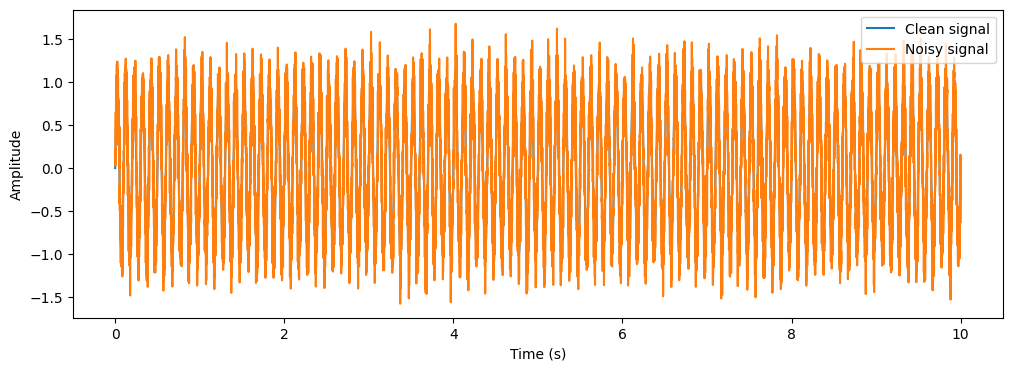

In [5]:
# Define signal parameters
sampling_rate = 1000  # Hz
duration = 10  # seconds
frequency = 10  # Hz
amplitude = 1  # arbitrary units

# Generate time vector
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Generate clean signal
x = amplitude * np.sin(2 * np.pi * frequency * t)

# Generate Gaussian white noise
noise_amplitude = 0.2  # arbitrary units
noise = noise_amplitude * np.random.randn(len(x))

# Add noise to signal
x_noisy = x + noise

# Plot signal and noisy signal
plt.figure(figsize=(12, 4))
plt.plot(t, x, label="Clean signal")
plt.plot(t, x_noisy, label="Noisy signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Amplitude masking

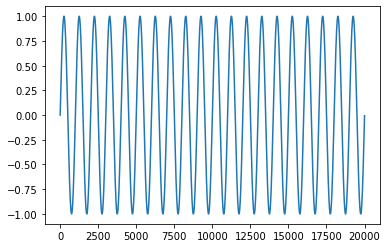

In [2]:
cycles = 20 # how many sine cycles
resolution = 20000 # how many datapoints to generate

length = np.pi * 2 * cycles
masked_signal_freq = np.sin(np.arange(0, length, length / resolution))
plt.plot(masked_signal_freq)

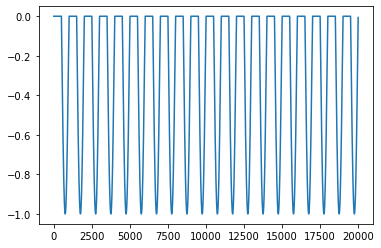

In [3]:
threshold = np.percentile(masked_signal_freq, 50)
amplitude_mask = np.zeros(len(masked_signal_freq))
amplitude_mask[masked_signal_freq < threshold] = 1
masked_signal_amp = masked_signal_freq * amplitude_mask
plt.plot(masked_signal_amp)

In [17]:
import librosa

In [19]:
win_size = 24
overlap = int(win_size/2)
spec = np.abs(librosa.stft(x_noisy))

spec_noise_est = np.percentile(spec, 10, axis=1)
spec_noise_est = np.repeat(spec_noise_est, win_size//2+1).reshape((win_size//2+1, -1)).T
spec_mask = np.zeros_like(spec)
spec_mask[:, spec < spec_noise_est] = 1
spec_subtracted = spec - (spec_mask * spec_noise_est)

signal_specsub = librosa.istft(spec_subtracted, hop_length=overlap)

ValueError: operands could not be broadcast together with shapes (1025,20) (1025,513) 

In [17]:
noise_factor = 0.00005

synthetic_pattern = np.sin(np.arange(0, len(x_noisy)) * 2 * np.pi/(24*64))

synthetic_pattern = synthetic_pattern / np.max(synthetic_pattern)
masked_signal_waveform = x_noisy + noise_factor * np.random.normal(size=len(x_noisy)) + synthetic_pattern

In [18]:
masked_signal_waveform

array([ 0.17929639,  0.22760548,  0.19506332, ...,  0.10274803,
       -0.1267435 , -0.12675646])

In [19]:
mean_val = np.mean(masked_signal_waveform)
std_val = np.std(masked_signal_waveform)
num_std = 2
outlier_mask = np.logical_or(masked_signal_waveform > mean_val + num_std*std_val, masked_signal_waveform < mean_val)
masked_signal_outlier = masked_signal_waveform.copy()
masked_signal_outlier[outlier_mask] = 0

In [20]:
masked_signal_outlier

array([0.17929639, 0.22760548, 0.19506332, ..., 0.10274803, 0.        ,
       0.        ])